In [ ]:
!pip install surprise

  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162675 sha256=575dfb781d1be2363f4e2bd7d57d94bcf59c2f5e7241283d6ae909273f1f4e32
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# --
from surprise import Dataset, SVD, KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
import pandas as pd
from surprise import accuracy
from surprise import BaselineOnly

# Getting the Data

## Read in users dataset

In [ ]:
column_names = ['user_id', 'song_id', 'play_count']
df = pd.read_csv("kaggle_visible_evaluation_triplets.txt", sep='\t', names=column_names)
df.head()

,user_id,song_id,play_count
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1


In [ ]:
# Define bins and labels, 1 through 10
bins = [1, 2, 3, 4, 5,6,7,8,9,10, float('inf')]
labels = [1, 2, 3, 4, 5,6,7,8,9,10]

# Bin the 'play_count' column
df['play_count_binned'] = pd.cut(df['play_count'], bins=bins, labels=labels, right=False)
df['play_count_binned'].value_counts()

1     839136
2     213712
3      95726
10     91034
5      73542
4      55158
6      31902
7      22317
8      16179
9      12227
Name: play_count_binned, dtype: int64

## Read in  a dataset of me and my peer’s

In [ ]:
# Read in  a dataset of me and my peer’s favorite songs with a play count of 10
mydf = pd.read_csv("my_songs.csv")
mydf

,user_id,song_id,play_count
0,Yanghua,SOQBUKY12A8C13A803,10
1,Yanghua,SONRVSJ12A8C13274D,10
2,Yanghua,SOXJICX12AB017F175,10
3,Yanghua,SONRCPD12A8AE46987,10
4,Yanghua,SODCJDY12A8AE4698D,5
5,Yanghua,SOMQADD12AB017BE1F,5
6,Yanghua,SOWLICH12A8C13C9EB,5
7,Yanghua,SORBZFR12A8AE46E4D,5
8,Yanghua,SOEAHRL12A8C137990,5
9,Yanghua,SOGQJKF12A8C13729E,5


In [ ]:
# Append my dataset to df
df = pd.concat([df,mydf],axis=0)
df.head()

,user_id,song_id,play_count,play_count_binned
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,1


## Read in artist and songs dataset: unique_tracks.txt

In [ ]:
df_tracks = pd.read_csv('unique_tracks.txt',
                       sep='<SEP>', names=['track_id','song_id','artist_name','song'], engine='python')
df_tracks.head()

,track_id,song_id,artist_name,song
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


# Preprocessing

## Merging two dataset

In [ ]:
# Merging two dataset and drop duplicates 'song_id
merged_df = pd.merge(df, df_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450948 entries, 0 to 1450947
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   user_id            1450948 non-null  object  
 1   song_id            1450948 non-null  object  
 2   play_count         1450948 non-null  int64   
 3   play_count_binned  1450933 non-null  category
 4   track_id           1450948 non-null  object  
 5   artist_name        1450948 non-null  object  
 6   song               1450947 non-null  object  
dtypes: category(1), int64(1), object(5)
memory usage: 78.9+ MB


# Exploratory Data Analysis

## List Top 5 Users listen the most and show the play counts
- The top 5 users play counts are 1305, 1267, 1200, 1192, and 1184.

In [ ]:
# Display the top users
most_listened_users = df.groupby('user_id')['play_count'].sum().nlargest(5)

# Rename the second column to 'counts'
most_listened_users = most_listened_users.rename('counts')

# Convert to DataFrame
most_listened_users_df = most_listened_users.reset_index().head()


# Display the table
print(most_listened_users_df )

                                    user_id  counts
0  090b841eaf56d343a26625c2c6d08b823927bc4f    1305
1  938c2632d43eeadb8a83a7cc254d014f9cea6afe    1267
2  1c5aa998482a40abfd020759e7d757eb6c510e72    1200
3  c6150292374fb1dad89982367b3245dd5004c718    1192
4  5a9375e46a7e9b869058c7bc0e820e00d77f3e0b    1184


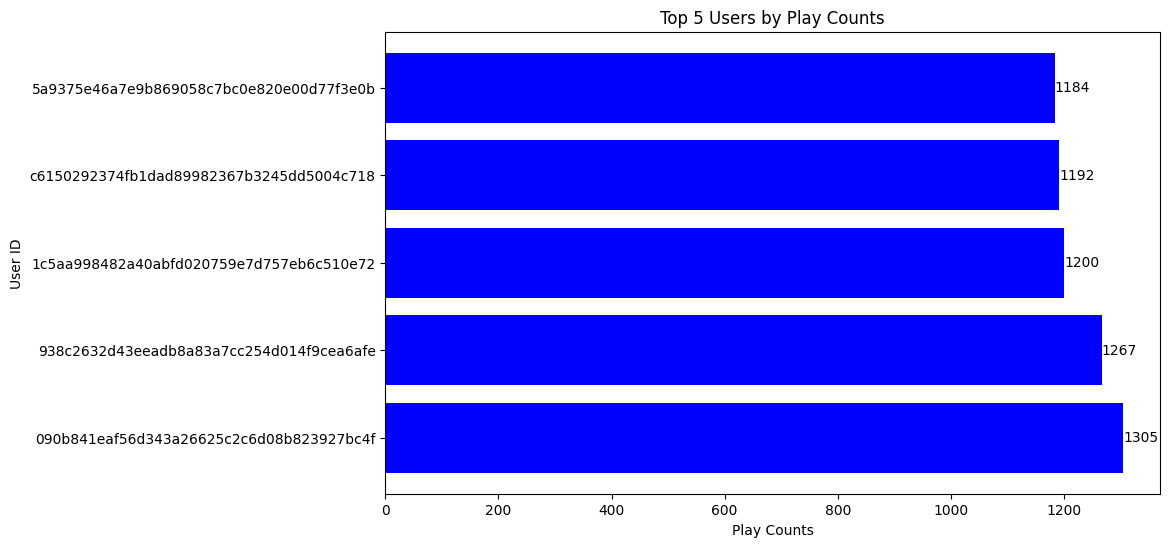

In [ ]:
# Create a bar chart

import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(most_listened_users_df['user_id'], most_listened_users_df['counts'], color='blue')

plt.title('Top 5 Users by Play Counts')
plt.xlabel('Play Counts')
plt.ylabel('User ID')

# Add numbers on the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width()}',
             va='center', ha='left', fontsize=10, color='black')

plt.show()


## How many unique songs and unique users
- The number of unique songs are 163209.
- The number of unique user are 110002.
- The number of unique play count are 4624500.

In [ ]:
print(f"No. of unique songs: {df['song_id'].nunique()}")
print(f"No. of unique users: {df['user_id'].nunique()}")
print(f"No. of unique play counts: {df['play_count'].sum()}")

No. of unique songs: 163210
No. of unique users: 110002
No. of unique play counts: 4624500


## The most popular Songs

## The most popular songs and artists

In [ ]:
# list users listen the most
popular = merged_df[['artist_name','song','play_count','user_id']]

artist_pop = popular.pivot_table(values=['play_count'],index = ['artist_name','song'] ,aggfunc = 'sum')

artist_pop = artist_pop.sort_values(by='play_count',ascending=False)

artist_pop = artist_pop.reset_index()

pop_artist_songs =artist_pop.head(10)
pop_artist_songs

,artist_name,song,play_count
0,Dwight Yoakam,You're The One,35432
1,Björk,Undo,33179
2,Kings Of Leon,Revelry,24359
3,Harmonia,Sehr kosmisch,19454
4,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,17115
5,Florence + The Machine,Dog Days Are Over (Radio Edit),14279
6,OneRepublic,Secrets,12392
7,Sam Cooke,Ain't Misbehavin,11610
8,Tub Ring,Invalid,10794
9,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,10515


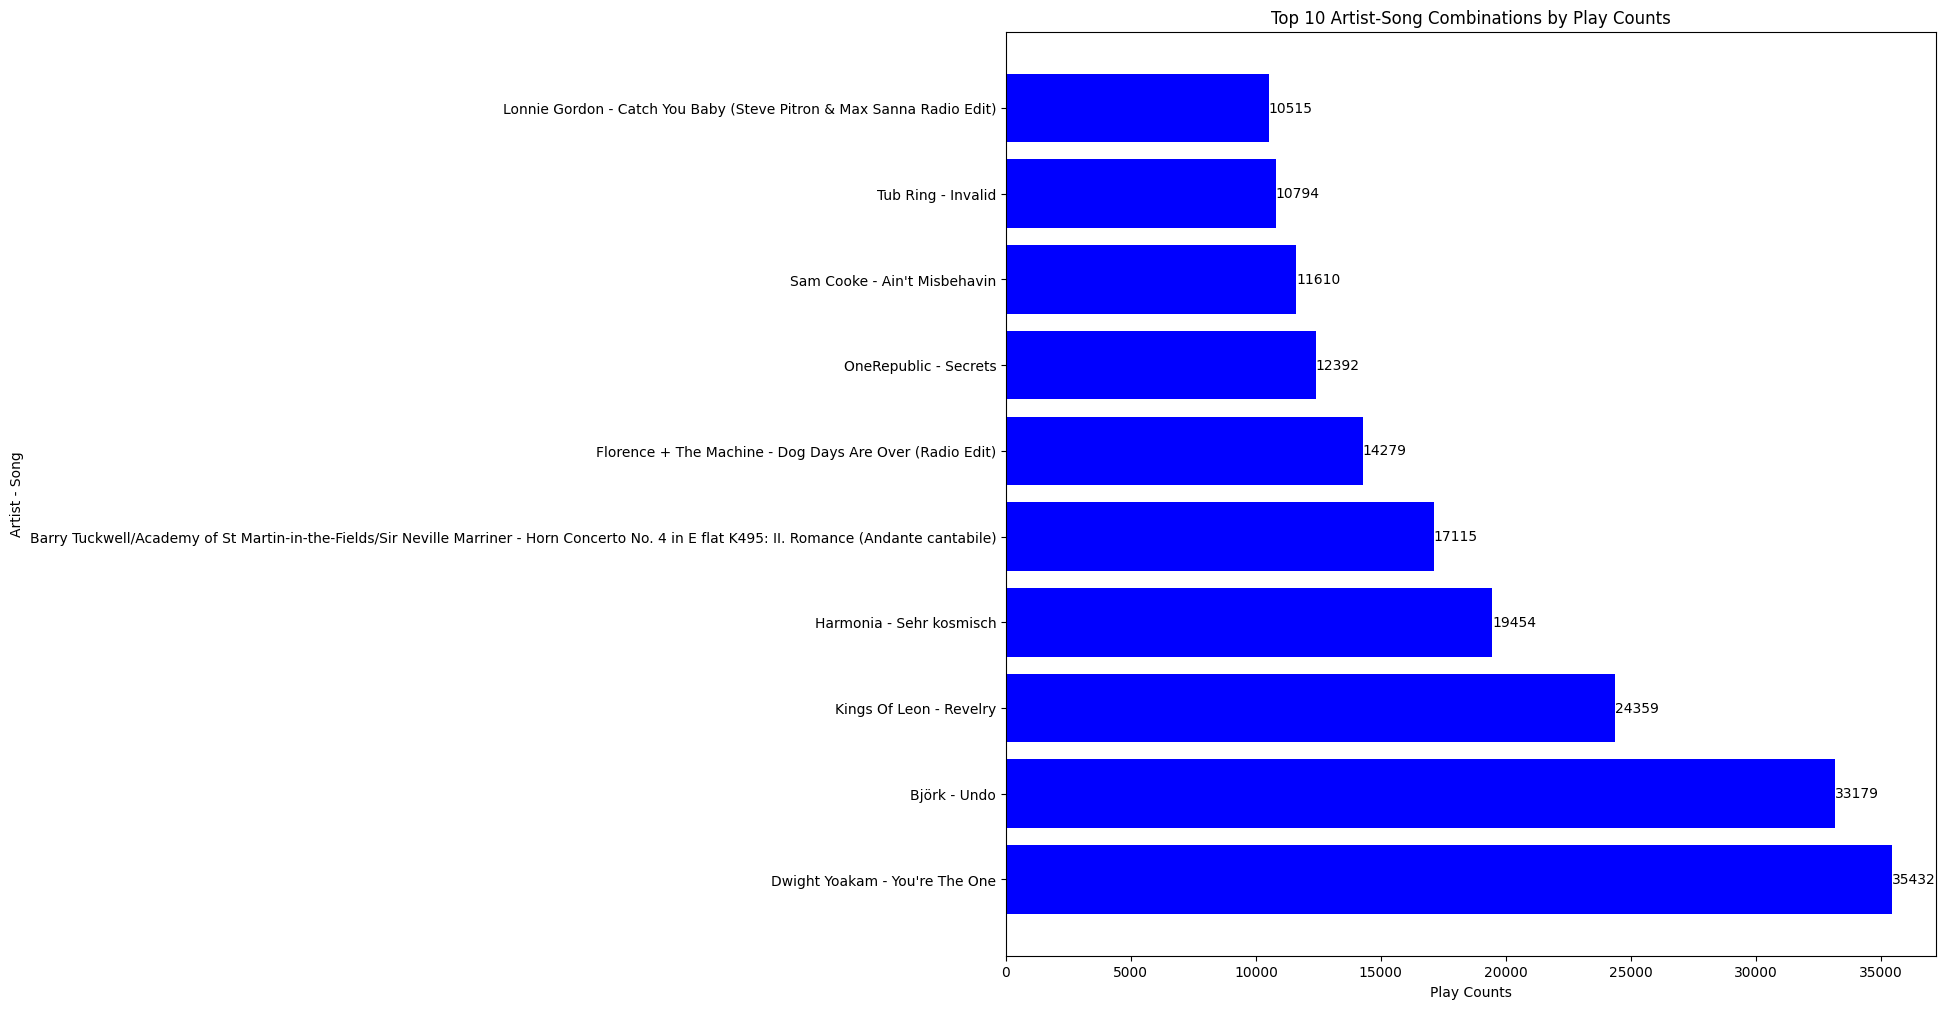

In [ ]:
import matplotlib.pyplot as plt

# Create a bar plot
plt.figure(figsize=(12, 12))
bars = plt.barh(pop_artist_songs['artist_name'] + ' - ' + pop_artist_songs['song'], pop_artist_songs['play_count'], color='blue')
plt.title('Top 10 Artist-Song Combinations by Play Counts')
plt.ylabel('Artist - Song')
plt.xlabel('Play Counts')

# Add numbers on the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.0f}',
             va='center', ha='left', fontsize=10, color='black')

plt.show()

## The number of unique users have listened to the most popular songs and artists

In [ ]:
# Filters the original DataFrame (merged_df) to include only rows where the artist and song are in the top artist-song combinations (pop_artist_songs)
filtered_df = merged_df[merged_df[['artist_name', 'song']].apply(tuple, axis=1).isin(pop_artist_songs[['artist_name', 'song']].apply(tuple, axis=1))]

In [ ]:
# unique users have listened to the most popular songs and artists
unique_users_per_song = filtered_df.groupby('song')['user_id'].nunique().reset_index().rename(columns={'user_id': 'number of unique users'})

# Display the result
print(unique_users_per_song)

                                                song  number of unique users
0                                   Ain't Misbehavin                    1712
1  Catch You Baby (Steve Pitron & Max Sanna Radio...                    2097
2                     Dog Days Are Over (Radio Edit)                    3780
3  Horn Concerto No. 4 in E flat K495: II. Romanc...                    3272
4                                            Invalid                    1619
5                                            Revelry                    3672
6                                            Secrets                    3430
7                                      Sehr kosmisch                    5043
8                                               Undo                    4483
9                                     You're The One                    4136


In [ ]:
# show the Top 10 popular songs and artists with the play count and number of unique users for each song
merged_df_1 = pd.merge(unique_users_per_song, pop_artist_songs, how='left', on='song')
merged_df_1 = merged_df_1 .sort_values(by='play_count',ascending=False)
merged_df_1 = merged_df_1[['song','artist_name','play_count','number of unique users']]
merged_df_1

,song,artist_name,play_count,number of unique users
9,You're The One,Dwight Yoakam,35432,4136
8,Undo,Björk,33179,4483
5,Revelry,Kings Of Leon,24359,3672
7,Sehr kosmisch,Harmonia,19454,5043
3,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,17115,3272
2,Dog Days Are Over (Radio Edit),Florence + The Machine,14279,3780
6,Secrets,OneRepublic,12392,3430
0,Ain't Misbehavin,Sam Cooke,11610,1712
4,Invalid,Tub Ring,10794,1619
1,Catch You Baby (Steve Pitron & Max Sanna Radio...,Lonnie Gordon,10515,2097


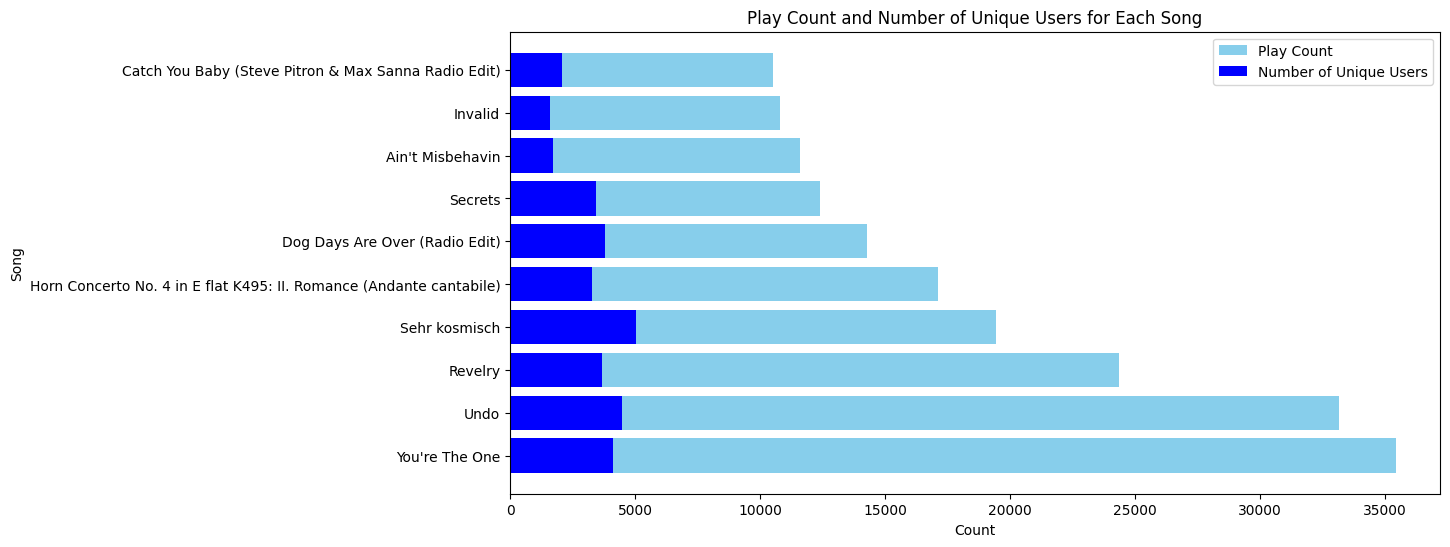

In [ ]:
# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(merged_df_1['song'], merged_df_1['play_count'], color='skyblue', label='Play Count')
plt.barh(merged_df_1['song'], merged_df_1['number of unique users'], color='blue', label='Number of Unique Users')

plt.title('Play Count and Number of Unique Users for Each Song')
plt.ylabel('Song')
plt.xlabel('Count')
plt.legend()
plt.show()

# Train & Evaluate Recommenders

## Create a Global BaselineOnly model

In [ ]:
# Set the seed
seed_value = 66

# Sample your DataFrame with the specified seed
merged_df = merged_df.sample(10000, random_state=seed_value)

In [ ]:
# Load data into a Surprise Dataset
reader = Reader(rating_scale=(merged_df['play_count_binned'].min(),
                              merged_df['play_count_binned'].max()))
data = Dataset.load_from_df(merged_df[['user_id','song_id','play_count_binned']], reader)


# Split data into training and testing sets, test set is made of 30% of the data
trainset, testset = train_test_split(data,test_size=0.3,random_state=seed_value)

In [ ]:
print("Evaluating Global Mean Baseline:")
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 5,
               'reg_i': 5}
algo_global = BaselineOnly(bsl_options=bsl_options)
algo_global.fit(trainset)
# Predict ratings for the testset
predictions_global = algo_global.test(testset)
# Compute and print RMSE
rmse_global = accuracy.rmse(predictions_global)
# Compute and print MAE
mae_global = accuracy.mae(predictions_global)

Evaluating Global Mean Baseline:
Estimating biases using als...
RMSE: 2.5684
MAE:  1.8848


## Create a basic SVD model

In [ ]:
# Use the SVD algorithm
svd_model = SVD()

# Train the algorithm on the trainset
svd_model.fit(trainset)

# Access properties
user_factors = svd_model.pu
item_factors = svd_model.qi
user_biases = svd_model.bu
item_biases = svd_model.bi
global_mean = trainset.global_mean

# You can now analyze these properties, such as their shapes, distributions, etc.
print("User factors shape:", user_factors.shape)
print("Item factors shape:", item_factors.shape)

User factors shape: (6707, 100)
Item factors shape: (5552, 100)


In [ ]:
print("Evaluating basic SVD recomender model:\n")
# make predicitons
test_predictions = svd_model.test(testset)
# Compute and print RMSE
rmse = accuracy.rmse(test_predictions)
mae = accuracy.mae(test_predictions)


Evaluating basic SVD recomender model:

RMSE: 2.5693
MAE:  1.8877


## Hyperparameter tuning on the SVD (Singular Value Decomposition) algorithm

In [ ]:
from surprise.model_selection import GridSearchCV

# Define a parameter grid with different values for hyperparameters
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [5, 10, 20],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.05]
}

gs = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

2.5458940457247112
{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


In [ ]:
results = gs.cv_results
# Convert the dictionary into a Pandas DataFrame
results_df = pd.DataFrame.from_dict(results)

# Filter the DataFrame to show only the relevant columns
relevant_columns = ['param_n_factors', 'param_n_epochs', 'param_lr_all', 'param_reg_all', 'mean_test_rmse', 'mean_test_mae']
results_df = results_df[relevant_columns]

# Print the DataFrame
results_df

,param_n_factors,param_n_epochs,param_lr_all,param_reg_all,mean_test_rmse,mean_test_mae
0,50,5,0.002,0.02,2.554653,1.884268
1,50,5,0.002,0.05,2.554523,1.884182
2,50,5,0.005,0.02,2.551556,1.884590
3,50,5,0.005,0.05,2.551437,1.884440
4,50,10,0.002,0.02,2.552343,1.884449
5,50,10,0.002,0.05,2.552269,1.884392
6,50,10,0.005,0.02,2.548150,1.884562
7,50,10,0.005,0.05,2.548248,1.884543
8,50,20,0.002,0.02,2.549437,1.884733
9,50,20,0.002,0.05,2.549448,1.884497


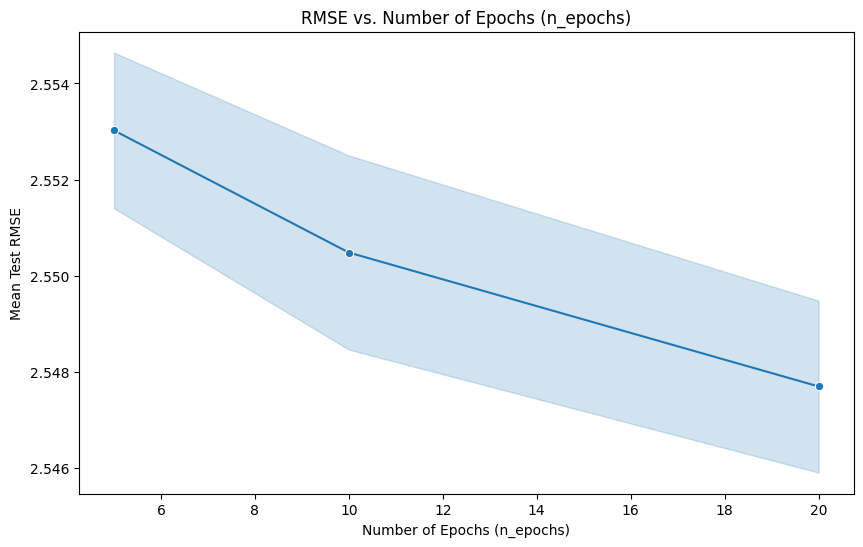

In [ ]:
filtered_df = results_df[results_df['param_n_factors'] == 100]  # Example filter

# Creating the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='param_n_epochs', y='mean_test_rmse', marker='o')
plt.title('RMSE vs. Number of Epochs (n_epochs)')
plt.xlabel('Number of Epochs (n_epochs)')
plt.ylabel('Mean Test RMSE')
plt.show()

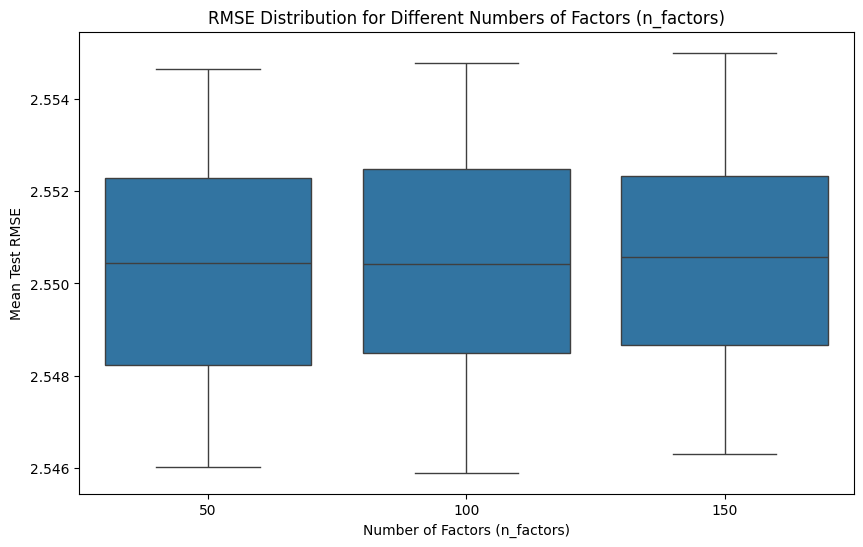

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='param_n_factors', y='mean_test_rmse')
plt.title('RMSE Distribution for Different Numbers of Factors (n_factors)')
plt.xlabel('Number of Factors (n_factors)')
plt.ylabel('Mean Test RMSE')
plt.show()

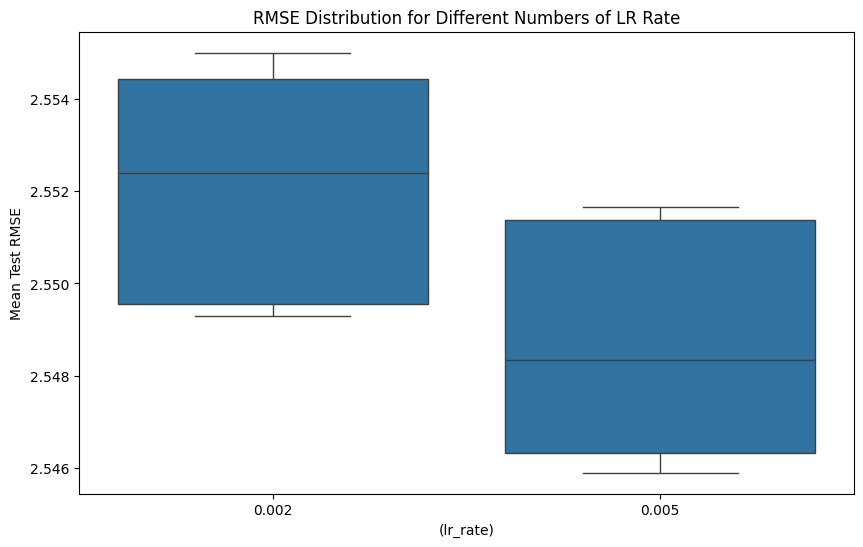

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='param_lr_all', y='mean_test_rmse')
plt.title('RMSE Distribution for Different Numbers of LR Rate')
plt.xlabel('(lr_rate)')
plt.ylabel('Mean Test RMSE')
plt.show()

## Refit w. Best Parameters
- SVD models often have hyperparameters that can be fine-tuned for better performance. Grid search or other hyperparameter optimization techniques can be applied to find the optimal set of parameters.
-chose the number of factors (n_factors) = 50 , the number of epochs (n_epochs) = 20 ,the learning rate (lr_all) = 0.005, and the regularization term (reg_all) = 0.05 .

In [ ]:
## Refit w. Best Parameters
best_params = gs.best_params['rmse']
svd_model1 = SVD(n_factors=best_params['n_factors'], n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
svd_model1.fit(trainset)

print("Evaluating SVD recommender model:\n")
# make predicitons
test_predictions = svd_model1.test(testset)
# Compute and print RMSE
rmse_s = accuracy.rmse(test_predictions)

# Compute and print MAE
mae_s = accuracy.mae(test_predictions)

Evaluating SVD recommender model:

RMSE: 2.5699
MAE:  1.8882


## Compare the Baseline() performance to that of the SVD.

In [ ]:
print("Evaluating SVD vs. Baseline:\n")
print(f"SVD RMSE: {rmse_s:.4f} ")
print(f"SVD MAE: {mae_s:.4f} ")

print(f"Baseline RMSE: {rmse_global:.4f} ")
print(f"Baseline MAE: {mae_global:.4f} ")

Evaluating SVD vs. Baseline:

SVD RMSE: 2.5699 
SVD MAE: 1.8882 
Baseline RMSE: 2.5684 
Baseline MAE: 1.8848 


## Even if Baseline() RMSE/MAE is lower than the SVD why would having a SVD be preferable to a baseline only model? ?

- First, baselines are simple models used as a point of comparison for more complex algorithms. They are crucial for understanding how much better a sophisticated model is compared to a simple approach. Thus, it is a fundamental in recommendation systems and any sophisticated model should exceed to be considered valuable, such as the model we used SVD should have a greater performance compare to the model used baseline.
- In this case I used golbal baseline algorithms.This is the simplest form of baseline. It involves calculating a single average rating across all users and items in the dataset and using this average as the prediction for all user-item pairs. It is used as a starting point.

- Secondly,Singular Value Decomposition (SVD) is a sophisticated matrix factorization technique commonly used in recommendation systems, particularly for collaborative filtering. It used to decompose user-item rating matrix into matrices representing latent (hidden) factors for users and items.
- In this case, I tries to learn the latent factors that best approximate the original user-item rating matrix. The goal is to minimize the difference between predicted and actual play_count_binned in the training set, thereby learning the preferences and characteristics of users and songs.

- It's worth noting that RMSE/MAE are evaluation metrics used to measure the accuracy and effectiveness of a model's predictions. However, there are other evaluation metrics, such as diversity and relativity. By utilizing SVD, it's possible to recommend songs to users that they haven't listened to before, but would likely enjoy.



# Answer the Following

## 1.	For a random sample of 5 users with 10 or more song plays make 5 recommendations of songs they have not listened to with your SVD.

In [ ]:
import random
# Filter users with 10 or more song plays
merged_df_full = pd.merge(df, df_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
user_counts = merged_df_full['user_id'].value_counts().to_frame()
users_with_10_or_more_plays = user_counts[user_counts['user_id']>=10].index.to_frame()

# Choose 5 random users from those with 10 or more plays
random_users = users_with_10_or_more_plays.sample(n=5, random_state=1)


# list the 5 users
random_users.index

Index(['24e4a7c1ab06a5083351dbaa0928c119a1189bf0',
       '928dbb35f316b01a07669cf52cacb9c100faeb89',
       'd5a958ee09e11863ffd1826c525b8706f6d8ec23',
       'afcf461757727791669cc5c6e53aa224cb06b10f',
       '46ab39037e5c822c4fbe73e78c7df86dc0201d7d'],
      dtype='object')

In [ ]:
def get_top_n_recommendations(user_id, data, model, n=5):
    # 1. Identify all unique songs in the dataset
    all_songs = merged_df_full['song_id'].unique()

    # 2. Filter out songs that the user has already listened
    listened_songs = merged_df_full[merged_df_full['user_id'] == user_id]['song_id'].unique()
    songs_to_predict = np.setdiff1d(all_songs, listened_songs)

    # 3. Use the model to predict
    predictions = [model.predict(user_id, Song).est for Song in songs_to_predict]

    # 4. Combine songs and predictions into a list of tuples and sort them
    songs_predictions = list(zip(songs_to_predict, predictions))
    songs_predictions.sort(key=lambda x: x[1], reverse=True)

    # Return the top n beers
    return songs_predictions[:n]

# Example usage
user_id = 'Yanghua'  # replace with the user ID
top_songs = get_top_n_recommendations(user_id, merged_df_full, svd_model1, n=5)
print(f"Top 5 Song Recommendations for : {user_id}")

pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
merged_pred = pd.merge(pred, df_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
merged_pred

Top 5 Song Recommendations for : Yanghua


,song_id,play_count,track_id,artist_name,song
0,SOUFTBI12AB0183F65,4.629704,TRIXAZF128F421EE64,Tub Ring,Invalid
1,SOMMONH12A6D4F41CD,3.896780,TRMCMYP128F145BC3D,Beastie Boys,The Maestro
2,SOLRGNF12AB0187CF4,3.835628,TRGGPRP128F932F615,Simon Harris,Sample Track 2
3,SOAUWYT12A81C206F1,3.752198,TRGXQES128F42BA5EB,Björk,Undo
4,SOFRQTD12A81C233C0,3.710288,TRDMBIJ128F4290431,Harmonia,Sehr kosmisch


In [ ]:
# recommder songs to the choosen random_users
for user_id in random_users.index:
    # Example usage
    top_songs = get_top_n_recommendations(user_id, merged_df_full, svd_model1, n=5)
    print(f"Top 5 Song Recommendations for User {user_id}:\n")

    pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
    merged_pred = pd.merge(pred, df_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
    merged_pred.drop(columns=['track_id'], inplace=True)
    print(merged_pred)
    print()

Top 5 Song Recommendations for User 24e4a7c1ab06a5083351dbaa0928c119a1189bf0:

              song_id  play_count   artist_name            song
0  SOUFTBI12AB0183F65    4.629704      Tub Ring         Invalid
1  SOMMONH12A6D4F41CD    3.896780  Beastie Boys     The Maestro
2  SOLRGNF12AB0187CF4    3.835628  Simon Harris  Sample Track 2
3  SOAUWYT12A81C206F1    3.752198         Björk            Undo
4  SOFRQTD12A81C233C0    3.710288      Harmonia   Sehr kosmisch

Top 5 Song Recommendations for User 928dbb35f316b01a07669cf52cacb9c100faeb89:

              song_id  play_count   artist_name            song
0  SOUFTBI12AB0183F65    4.629704      Tub Ring         Invalid
1  SOMMONH12A6D4F41CD    3.896780  Beastie Boys     The Maestro
2  SOLRGNF12AB0187CF4    3.835628  Simon Harris  Sample Track 2
3  SOAUWYT12A81C206F1    3.752198         Björk            Undo
4  SOFRQTD12A81C233C0    3.710288      Harmonia   Sehr kosmisch

Top 5 Song Recommendations for User d5a958ee09e11863ffd1826c525b8706f6d8

## 2.	Recommendation systems should provide “relevant” recommendations expanding the user’s pool of options (songs in our case) what would you do to improve your recommendation to expand a user’s relevant song recommendation pool?

- If we could have more information about song's genre, lyrics, we could incorporate content-based filtering to recommend songs. This helps in diversifying recommendations by focusing on the characteristics of the items.For example, if the user has listened to one piece of music from the album, we recommend other pieces of music from the album to the user, and if the user listens to the song and listens to it many times, we can record the performance and update the database so that we can combine the content-based and user-based model to make better recommendations.
- Since we used a random sample of 10000 records, the model we created cann't cover all the features of orginal data, thus, there still have some room to increase the relativity and diverstiy of recommendations.

## 3.	What are your top 10 recommendations for a net new user? That is a user with no user/song play count? essentially the cold start problem.
- For a net new user, since we have limited information, we could make a non-personalized recommendations of songs.For example, recommend the songs that has the top 10 play count. These are likely to be well-received by a board audience.

In [ ]:
# list TOP 10 songs that users listen the most
popular = merged_df_full[['artist_name','song','play_count','user_id']]

artist_pop = popular.pivot_table(values=['play_count'],index = ['artist_name','song'] ,aggfunc = 'sum')

artist_pop = artist_pop.sort_values(by='play_count',ascending=False)

artist_pop = artist_pop.reset_index()

pop_artist_songs =artist_pop.head(10)
print(f"Top 10 Song Recommendations for new users:")
pop_artist_songs


Top 10 Song Recommendations for new users:


,artist_name,song,play_count
0,Dwight Yoakam,You're The One,35432
1,Björk,Undo,33179
2,Kings Of Leon,Revelry,24359
3,Harmonia,Sehr kosmisch,19454
4,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,17115
5,Florence + The Machine,Dog Days Are Over (Radio Edit),14279
6,OneRepublic,Secrets,12392
7,Sam Cooke,Ain't Misbehavin,11610
8,Tub Ring,Invalid,10794
9,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,10515


## 4.	What are your top 10 recommendations for you and your peer?
a.	Do the recommendations make sense? What could you do to improve them? Do you think an Item based KNN might better?  
- The recommended playlists are the same for me and my peer, because the play counts of my peers and I are similar, so because of the similarity of play counts, there is no varibality. Therefore, based on user and play counts, the playlists recommended to me and my partner are the same.


In [ ]:
# Top 10 recommendations for me
user_id = 'Yanghua'  # replace with the user ID
top_songs = get_top_n_recommendations(user_id, merged_df_full, svd_model1, n=10)
print(f"Top 10 Song Recommendations for : {user_id}")

pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
merged_pred = pd.merge(pred, df_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
merged_pred

Top 10 Song Recommendations for : Yanghua


,song_id,play_count,track_id,artist_name,song
0,SOUFTBI12AB0183F65,4.629704,TRIXAZF128F421EE64,Tub Ring,Invalid
1,SOMMONH12A6D4F41CD,3.896780,TRMCMYP128F145BC3D,Beastie Boys,The Maestro
2,SOLRGNF12AB0187CF4,3.835628,TRGGPRP128F932F615,Simon Harris,Sample Track 2
3,SOAUWYT12A81C206F1,3.752198,TRGXQES128F42BA5EB,Björk,Undo
4,SOFRQTD12A81C233C0,3.710288,TRDMBIJ128F4290431,Harmonia,Sehr kosmisch
5,SOTCMDJ12A6D4F8528,3.668739,TRZJNDO128EF343498,Angels and Airwaves,The Gift
6,SODARWQ12A6D4F8447,3.644039,TRZWFRK128F1462735,Paul Mauriat,Love Is Blue
7,SOFXDBI12A8AE48DA3,3.639314,TRXIWJV128F4238B00,Sean Paul,Gimme The Light
8,SOIOHVE12AB018CA91,3.606211,TRPQFWS12903CE0683,Livvi Franc,Automatik
9,SOPUCYA12A8C13A694,3.572784,TRFQOSP128F427C2B2,Five Iron Frenzy,Canada


In [ ]:
# Top 10 recommendations for my peer
user_id = 'namtr'  # replace with the user ID
top_songs = get_top_n_recommendations(user_id, merged_df_full, svd_model1, n=10)
print(f"Top 10 Song Recommendations for : {user_id}")

pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
merged_pred = pd.merge(pred, df_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
merged_pred

Top 10 Song Recommendations for : namtr


,song_id,play_count,track_id,artist_name,song
0,SOUFTBI12AB0183F65,4.629704,TRIXAZF128F421EE64,Tub Ring,Invalid
1,SOMMONH12A6D4F41CD,3.896780,TRMCMYP128F145BC3D,Beastie Boys,The Maestro
2,SOLRGNF12AB0187CF4,3.835628,TRGGPRP128F932F615,Simon Harris,Sample Track 2
3,SOAUWYT12A81C206F1,3.752198,TRGXQES128F42BA5EB,Björk,Undo
4,SOFRQTD12A81C233C0,3.710288,TRDMBIJ128F4290431,Harmonia,Sehr kosmisch
5,SOTCMDJ12A6D4F8528,3.668739,TRZJNDO128EF343498,Angels and Airwaves,The Gift
6,SODARWQ12A6D4F8447,3.644039,TRZWFRK128F1462735,Paul Mauriat,Love Is Blue
7,SOFXDBI12A8AE48DA3,3.639314,TRXIWJV128F4238B00,Sean Paul,Gimme The Light
8,SOIOHVE12AB018CA91,3.606211,TRPQFWS12903CE0683,Livvi Franc,Automatik
9,SOPUCYA12A8C13A694,3.572784,TRFQOSP128F427C2B2,Five Iron Frenzy,Canada


## KNNBasic


## Item Based

In [ ]:
knn_item = KNNBasic(k=10,
                     min_k=1,
                     sim_options={'name':
                                  'cosine',
                                  'user_based': False}) # Item

knn_item.fit(trainset)
knn_predictions_item = knn_item.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
print("Evaluating KNN ITEM recomender model:\n")
# make predicitons
test_predictions = knn_item.test(testset)
# Compute and print RMSE
rmse_ki = accuracy.rmse(test_predictions)

# Compute and print MAE
mae_ki = accuracy.mae(test_predictions)

print("Evaluating KNN-User vs. Baseline:\n")
print(f"RMSE: {rmse_ki:.4f} VS. baseline: {rmse_s:.4f}")
print(f"MAE: {mae_ki:.4f} VS. baseline: {mae_s:.4f}")

Evaluating KNN ITEM recomender model:

RMSE: 2.5782
MAE:  1.8847
Evaluating KNN-User vs. Baseline:

RMSE: 2.5782 VS. baseline: 2.5699
MAE: 1.8847 VS. baseline: 1.8882


- Item-based KNN relies on the similarity between items (songs) to make recommendations, which can be easy to understand and interpret.KNN can potentially offer more serendipitous recommendations since it relies on item similarities rather than underlying latent factors.If we perfer increase relativity, we perfer use KNN.But KNN may face challenges when new items are introduced since they lack historical interaction data for similarity calculations.Also, KNN is less deversity compare to SVD.The recommendation based on KNN algorithm is relatively fixed, and the recommended song list has a higher repetition rate.
- SVD's recommendations are based on latent factor that represent user preferences and item characteristics. The recommendation based on SVD algorithm is more diversity, and the recommended song list has a lower repetition rate.
- Thus, my recommendation is we could use both models to recommend songs and combine the recommend songs to the users.